# Image FFT shifting
See allso Check XIlinx FFT.ipynb

# Let's jsut check what a FFTSHIFT looks like


In [1]:
from pylab import *
import numpy as np
from astropy.io import fits
%matplotlib notebook

In [2]:
N = 16
v = np.arange(N*N).reshape(N,N)

def mkv(N):
    for i in range(N):
        for j in range(N):
            if j> i:
                v[i,j] = i*N+j
            elif j<i:
                v[i,j] = j*N+i
            else:
                v[i,j]= N*N
    return v



<IPython.core.display.Javascript object>


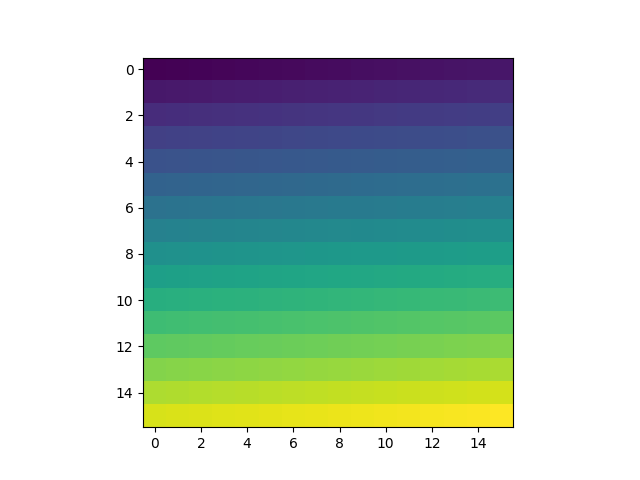

In [3]:
figure()
imshow(v)


<IPython.core.display.Javascript object>


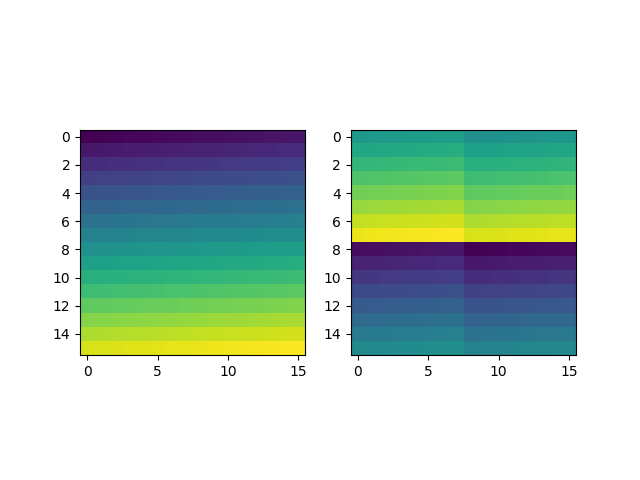

In [4]:
fig, ax = subplots(1,2)
ax[0].imshow(v)
ax[1].imshow(np.fft.fftshift(v))

# Run HW gridding in SW for small number of antennas to see what's going on

In [5]:
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

In [6]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
#fits='/data/craco/ban115/test_data/nant3/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 3 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, subtract=True, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
parsing values --ndm 2 --max-nbl 3 


/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(254, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(0, 251)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on

Upper registers [(3, 1), (4, 1), (34, 2), (35, 2), (36, 2), (37, 2), (38, 2), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (87, 2), (88, 2), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (101, 2), (102, 2), (103, 2)]
Lower registers [(1, 3), (1, 4), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (2, 8), (4, 8), (2, 9), (3, 9), (4, 9), (5, 9), (3, 10), (5, 10), (7, 10), (3, 11), (5, 11), (6, 11), (7, 11), (7, 12), (8, 12), (8, 13), (9, 13), (7, 14), (8, 14), (9, 14), (8, 15), (8, 16), (9, 16), (2, 17)]


In [7]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources
        vis = amp*np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

<IPython.core.display.Javascript object>


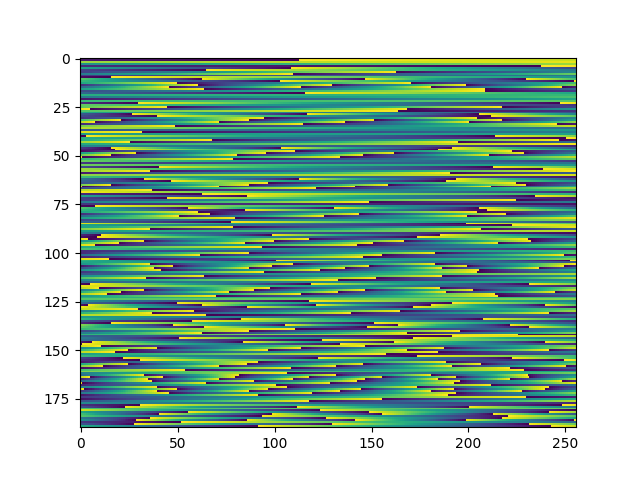

In [8]:
dpoint = pointsource(64,(np.radians(0.2), np.radians(0.3)),plan)
figure()
imshow(np.angle(dpoint), aspect='auto', interpolation='none')

In [9]:
import craco_pybind11
import craco_pybind11.ddgrid_reader
import craco_pybind11.grid
nchunk_time = plan.nchunk_time
nchunk_time = 1
nparallel_uvin, nparallel_uvout, h_nparallel_uvout, lut = get_grid_lut_from_plan(plan)
nuvrest = nparallel_uvin*2//8
NUVWIDE = 8
OUTPUT_NT = 2
OUTPUT_NUV = 2
ncu = 4
ndm = plan.nd
tblk = 0
do_load_lut = 1


In [10]:
nchunk_time

1

In [11]:
outputs = np.zeros((ncu, ndm, nchunk_time, nuvrest, NUVWIDE//OUTPUT_NUV, OUTPUT_NT, OUTPUT_NUV, 2), dtype=np.int16)

In [12]:
mainbuf_shape = (664, 186, 11, 256, 8, 2)
mainbuf = np.zeros(mainbuf_shape, dtype=np.int16)


In [13]:
mainbuf[:]= 0
mainbuf_hw = mainbuf.copy()
npix = 256
blid_grid = np.zeros((npix,npix))
for irun, r in enumerate(plan.fdmt_plan.runs):
    for icell, c in enumerate(r.cells):
        #print(c.uvpix, c.nchan)
        blid = c.blid
        ibl = np.where(plan.baseline_order == blid)[0][0]
        assert plan.baseline_order[ibl] == blid
        v = dpoint[ibl, c.chan_slice].sum()
        mainbuf[irun, 0, 0, 0, icell, :] = (v.real, v.imag) #c.nchan
        
        if c.is_lower:
            v = v.conj()
        
        mainbuf_hw[irun, 0, 0, 0, icell, :] = (v.real, v.imag) #c.nchan
        print(irun, icell, blid, ibl, v, c.is_upper, c.chan_slice, c, c.uvpix_upper, c.uvpix_lower)
    
        blid_grid[c.uvpix[1], c.uvpix[0]] = blid
        
        #pass
        
        
#mainbuf.sum()
#mainbuf[:,0,0,:,:,0] = 1

0 0 3092.0 161 (-542.3425+1971.7074j) True slice(0, 32, None) Cell blid=3092.0 chan=0-31 freq=734499993.896500-765499995.369000 uvpix=(252, 7) upper_idx=2016 uvpix_upper=(252, 7) (252, 7) (4, 249)
0 1 2578.0 142 (959.2389-1799.9453j) False slice(0, 32, None) Cell blid=2578.0 chan=0-31 freq=734499993.896500-765499995.369000 uvpix=(247, 253) upper_idx=771 uvpix_upper=(9, 3) (9, 3) (247, 253)
0 2 2314.0 124 (173.5816+2040.2867j) True slice(0, 32, None) Cell blid=2314.0 chan=0-31 freq=734499993.896500-765499995.369000 uvpix=(240, 7) upper_idx=2004 uvpix_upper=(240, 7) (240, 7) (16, 249)
0 3 1030.0 55 (-147.89758+2039.3044j) True slice(0, 32, None) Cell blid=1030.0 chan=0-31 freq=734499993.896500-765499995.369000 uvpix=(249, 9) upper_idx=2508 uvpix_upper=(249, 9) (249, 9) (7, 247)
0 4 774.0 39 (1919.5233+713.9003j) True slice(0, 32, None) Cell blid=774.0 chan=0-31 freq=734499993.896500-765499995.369000 uvpix=(246, 5) upper_idx=1511 uvpix_upper=(246, 5) (246, 5) (10, 251)
0 5 772.0 37 (572.1

24 7 2832.0 149 (15.732328+678.5311j) True slice(16, 27, None) Cell blid=2832.0 chan=16-26 freq=750499994.656500-760499995.131500 uvpix=(253, 190) upper_idx=30748 uvpix_upper=(253, 190) (253, 190) (3, 66)
25 0 2829.0 146 (-595.0435+331.86206j) True slice(7, 18, None) Cell blid=2829.0 chan=7-17 freq=741499994.229000-751499994.704000 uvpix=(66, 27) upper_idx=6600 uvpix_upper=(66, 27) (66, 27) (190, 229)
25 1 2324.0 134 (525.7091+454.94092j) True slice(0, 11, None) Cell blid=2324.0 chan=0-10 freq=734499993.896500-744499994.371500 uvpix=(237, 49) upper_idx=11556 uvpix_upper=(237, 49) (237, 49) (19, 207)
25 2 2068.0 123 (460.3417+532.6301j) True slice(0, 11, None) Cell blid=2068.0 chan=0-10 freq=734499993.896500-744499994.371500 uvpix=(205, 27) upper_idx=6739 uvpix_upper=(205, 27) (205, 27) (51, 229)
25 3 2067.0 122 (598.42773+358.3463j) True slice(4, 15, None) Cell blid=2067.0 chan=4-14 freq=738499994.086500-748499994.561500 uvpix=(189, 3) upper_idx=951 uvpix_upper=(189, 3) (189, 3) (67, 2

51 1 781.0 46 (-229.3378-304.4537j) False slice(26, 32, None) Cell blid=781.0 chan=26-31 freq=760499995.131500-765499995.369000 uvpix=(36, 37) upper_idx=32194 uvpix_upper=(220, 219) (220, 219) (36, 37)
51 2 528.0 32 (-51.38014+375.3905j) True slice(3, 9, None) Cell blid=528.0 chan=3-8 freq=737499994.039000-742499994.276500 uvpix=(221, 201) upper_idx=31376 uvpix_upper=(221, 201) (221, 201) (35, 55)
51 3 521.0 25 (-16.604366+382.90298j) True slice(0, 6, None) Cell blid=521.0 chan=0-5 freq=734499993.896500-739499994.134000 uvpix=(245, 234) upper_idx=32654 uvpix_upper=(245, 234) (245, 234) (11, 22)
51 4 273.0 15 (352.5445-139.6865j) False slice(13, 19, None) Cell blid=273.0 chan=13-18 freq=747499994.514000-752499994.751500 uvpix=(207, 210) upper_idx=10744 uvpix_upper=(49, 46) (49, 46) (207, 210)
51 5 269.0 11 (375.80392+61.8798j) False slice(20, 26, None) Cell blid=269.0 chan=20-25 freq=754499994.846500-759499995.084000 uvpix=(35, 40) upper_idx=32081 uvpix_upper=(221, 216) (221, 216) (35, 

78 0 529.0 33 (43.588497+46.861958j) False slice(31, 32, None) Cell blid=529.0 chan=31-31 freq=765499995.369000-765499995.369000 uvpix=(204, 206) upper_idx=11577 uvpix_upper=(52, 50) (52, 50) (204, 206)
78 1 529.0 33 (-48.94714-41.23321j) False slice(0, 1, None) Cell blid=529.0 chan=0-0 freq=734499993.896500-734499993.896500 uvpix=(207, 208) upper_idx=11161 uvpix_upper=(49, 48) (49, 48) (207, 208)
78 2 516.0 20 (52.33465+36.83863j) False slice(0, 1, None) Cell blid=516.0 chan=0-0 freq=734499993.896500-734499993.896500 uvpix=(252, 253) upper_idx=766 uvpix_upper=(4, 3) (4, 3) (252, 253)
78 3 272.0 14 (56.19245+30.633453j) True slice(31, 32, None) Cell blid=272.0 chan=31-31 freq=765499995.369000-765499995.369000 uvpix=(221, 202) upper_idx=31430 uvpix_upper=(221, 202) (221, 202) (35, 54)
79 0 2835.0 152 (730.02905-1884.5944j) False slice(32, 64, None) Cell blid=2835.0 chan=32-63 freq=766499995.416500-797499996.889000 uvpix=(242, 249) upper_idx=1778 uvpix_upper=(14, 7) (14, 7) (242, 249)
79

105 0 2317.0 127 (482.67242+457.12622j) False slice(35, 46, None) Cell blid=2317.0 chan=35-45 freq=769499995.559000-779499996.034000 uvpix=(46, 61) upper_idx=31020 uvpix_upper=(210, 195) (210, 195) (46, 61)
105 1 2067.0 122 (-263.3043+645.9092j) True slice(37, 48, None) Cell blid=2067.0 chan=37-47 freq=771499995.654000-781499996.129000 uvpix=(186, 4) upper_idx=1200 uvpix_upper=(186, 4) (186, 4) (70, 252)
105 2 2067.0 122 (-528.5435+455.15884j) True slice(48, 59, None) Cell blid=2067.0 chan=48-58 freq=782499996.176500-792499996.651500 uvpix=(185, 4) upper_idx=1199 uvpix_upper=(185, 4) (185, 4) (71, 252)
105 3 2062.0 117 (-382.13577+589.29565j) True slice(32, 43, None) Cell blid=2062.0 chan=32-42 freq=766499995.416500-776499995.891500 uvpix=(21, 6) upper_idx=1536 uvpix_upper=(21, 6) (21, 6) (235, 250)
105 4 2058.0 113 (-684.1792+116.908356j) False slice(32, 43, None) Cell blid=2058.0 chan=32-42 freq=766499995.416500-776499995.891500 uvpix=(206, 241) upper_idx=3770 uvpix_upper=(50, 15) (5

138 0 1293.0 77 (-251.26935-42.781963j) False slice(56, 60, None) Cell blid=1293.0 chan=56-59 freq=790499996.556500-793499996.699000 uvpix=(39, 48) upper_idx=31729 uvpix_upper=(217, 208) (217, 208) (39, 48)
138 1 1293.0 77 (-223.3526-122.80144j) False slice(60, 64, None) Cell blid=1293.0 chan=60-63 freq=794499996.746500-797499996.889000 uvpix=(40, 48) upper_idx=31728 uvpix_upper=(216, 208) (216, 208) (40, 48)
138 2 529.0 33 (-139.25165-213.00476j) False slice(60, 64, None) Cell blid=529.0 chan=60-63 freq=794499996.746500-797499996.889000 uvpix=(202, 204) upper_idx=11988 uvpix_upper=(54, 52) (54, 52) (202, 204)
138 3 522.0 26 (-17.609144+255.15878j) False slice(42, 46, None) Cell blid=522.0 chan=42-45 freq=776499995.891500-779499996.034000 uvpix=(227, 241) upper_idx=3749 uvpix_upper=(29, 15) (29, 15) (227, 241)
138 4 273.0 15 (-249.51941+50.751144j) False slice(46, 50, None) Cell blid=273.0 chan=46-49 freq=780499996.081500-783499996.224000 uvpix=(205, 208) upper_idx=11163 uvpix_upper=(5

161 1 521.0 25 (-271.84778-1521.6765j) True slice(71, 96, None) Cell blid=521.0 chan=71-95 freq=805499997.269000-829499998.409000 uvpix=(243, 232) upper_idx=32607 uvpix_upper=(243, 232) (243, 232) (13, 24)
161 2 1298.0 82 (-1483.2532-161.27475j) False slice(65, 89, None) Cell blid=1298.0 chan=65-88 freq=799499996.984000-822499998.076500 uvpix=(221, 246) upper_idx=2540 uvpix_upper=(35, 10) (35, 10) (221, 246)
161 3 779.0 44 (239.23355+1513.9423j) True slice(70, 94, None) Cell blid=779.0 chan=70-93 freq=804499997.221500-827499998.314000 uvpix=(222, 11) upper_idx=2972 uvpix_upper=(222, 11) (222, 11) (34, 245)
161 4 264.0 6 (-1489.0918+313.96844j) True slice(64, 88, None) Cell blid=264.0 chan=64-87 freq=798499996.936500-821499998.029000 uvpix=(24, 3) upper_idx=786 uvpix_upper=(24, 3) (24, 3) (232, 253)
161 5 4884.0 189 (-1078.7471+917.2776j) False slice(64, 87, None) Cell blid=4884.0 chan=64-86 freq=798499996.936500-820499997.981500 uvpix=(17, 26) upper_idx=32554 uvpix_upper=(239, 230) (23

190 3 3091.0 160 (-494.63388+290.29868j) False slice(64, 73, None) Cell blid=3091.0 chan=64-72 freq=798499996.936500-806499997.316500 uvpix=(235, 238) upper_idx=4458 uvpix_upper=(21, 18) (21, 18) (235, 238)
190 4 2833.0 150 (345.50433+442.7403j) True slice(67, 76, None) Cell blid=2833.0 chan=67-75 freq=801499997.079000-809499997.459000 uvpix=(237, 193) upper_idx=30924 uvpix_upper=(237, 193) (237, 193) (19, 63)
190 5 2832.0 149 (418.71973-375.0926j) True slice(64, 73, None) Cell blid=2832.0 chan=64-72 freq=798499996.936500-806499997.316500 uvpix=(253, 186) upper_idx=30478 uvpix_upper=(253, 186) (253, 186) (3, 70)
190 6 2577.0 141 (-509.68094-253.64206j) True slice(66, 75, None) Cell blid=2577.0 chan=66-74 freq=800499997.031500-808499997.411500 uvpix=(231, 220) upper_idx=32241 uvpix_upper=(231, 220) (231, 220) (25, 36)
190 7 2324.0 134 (-515.25934+246.5513j) True slice(87, 96, None) Cell blid=2324.0 chan=87-95 freq=821499998.029000-829499998.409000 uvpix=(235, 55) upper_idx=12775 uvpix_u

217 0 783.0 48 (-154.19263-203.73013j) False slice(92, 96, None) Cell blid=783.0 chan=92-95 freq=826499998.266500-829499998.409000 uvpix=(17, 198) upper_idx=13376 uvpix_upper=(239, 58) (239, 58) (17, 198)
217 1 781.0 46 (-164.19525+195.3498j) False slice(90, 94, None) Cell blid=781.0 chan=90-93 freq=824499998.171500-827499998.314000 uvpix=(39, 40) upper_idx=32077 uvpix_upper=(217, 216) (217, 216) (39, 40)
217 2 532.0 36 (91.86109+238.91864j) True slice(92, 96, None) Cell blid=532.0 chan=92-95 freq=826499998.266500-829499998.409000 uvpix=(222, 31) upper_idx=7662 uvpix_upper=(222, 31) (222, 31) (34, 225)
217 3 525.0 29 (61.909416+247.59047j) False slice(89, 93, None) Cell blid=525.0 chan=89-92 freq=823499998.124000-826499998.266500 uvpix=(36, 41) upper_idx=32040 uvpix_upper=(220, 215) (220, 215) (36, 41)
217 4 523.0 27 (-131.32047+219.73148j) True slice(64, 68, None) Cell blid=523.0 chan=64-67 freq=798499996.936500-801499997.079000 uvpix=(221, 11) upper_idx=2971 uvpix_upper=(221, 11) (22

250 1 1298.0 82 (-576.08636+674.77966j) False slice(98, 112, None) Cell blid=1298.0 chan=98-111 freq=832499998.551500-845499999.169000 uvpix=(220, 245) upper_idx=2786 uvpix_upper=(36, 11) (36, 11) (220, 245)
250 2 1296.0 80 (236.07454+813.8965j) True slice(114, 128, None) Cell blid=1296.0 chan=114-127 freq=848499999.311500-861499999.929000 uvpix=(220, 202) upper_idx=31429 uvpix_upper=(220, 202) (220, 202) (36, 54)
250 3 1295.0 79 (769.3624+431.8782j) False slice(114, 128, None) Cell blid=1295.0 chan=114-127 freq=848499999.311500-861499999.929000 uvpix=(20, 206) upper_idx=11761 uvpix_upper=(236, 50) (236, 50) (20, 206)
250 4 1293.0 77 (-41.828377+845.0424j) False slice(106, 120, None) Cell blid=1293.0 chan=106-119 freq=840499998.931500-853499999.549000 uvpix=(42, 51) upper_idx=31579 uvpix_upper=(214, 205) (214, 205) (42, 51)
250 5 1292.0 76 (373.64578+810.7902j) True slice(96, 110, None) Cell blid=1292.0 chan=96-109 freq=830499998.456500-843499999.074000 uvpix=(231, 32) upper_idx=7895 u

272 5 529.0 33 (517.59906+208.31581j) False slice(96, 105, None) Cell blid=529.0 chan=96-104 freq=830499998.456500-838499998.836500 uvpix=(200, 202) upper_idx=12395 uvpix_upper=(56, 54) (56, 54) (200, 202)
272 6 262.0 4 (-537.16504-207.862j) True slice(119, 128, None) Cell blid=262.0 chan=119-127 freq=853499999.549000-861499999.929000 uvpix=(244, 10) upper_idx=2749 uvpix_upper=(244, 10) (244, 10) (12, 246)
272 7 4371.0 185 (82.13794+498.84756j) False slice(98, 106, None) Cell blid=4371.0 chan=98-105 freq=832499998.551500-839499998.884000 uvpix=(5, 58) upper_idx=31238 uvpix_upper=(251, 198) (251, 198) (5, 58)
273 0 4371.0 185 (-494.58154+104.80754j) False slice(120, 128, None) Cell blid=4371.0 chan=120-127 freq=854499999.596500-861499999.929000 uvpix=(5, 60) upper_idx=31121 uvpix_upper=(251, 196) (251, 196) (5, 60)
273 1 4113.0 180 (68.26497+507.4247j) True slice(99, 107, None) Cell blid=4113.0 chan=99-106 freq=833499998.599000-840499998.931500 uvpix=(240, 8) upper_idx=2252 uvpix_upper=

302 5 3344.0 164 (-115.66654-53.785084j) True slice(120, 122, None) Cell blid=3344.0 chan=120-121 freq=854499999.596500-855499999.644000 uvpix=(177, 151) upper_idx=27357 uvpix_upper=(177, 151) (177, 151) (79, 105)
302 6 3090.0 159 (-112.64917-60.674324j) True slice(117, 119, None) Cell blid=3090.0 chan=117-118 freq=851499999.454000-852499999.501500 uvpix=(245, 212) upper_idx=31939 uvpix_upper=(245, 212) (245, 212) (11, 44)
302 7 3088.0 157 (-47.75505-118.57324j) True slice(96, 98, None) Cell blid=3088.0 chan=96-97 freq=830499998.456500-831499998.504000 uvpix=(246, 172) upper_idx=29400 uvpix_upper=(246, 172) (246, 172) (10, 84)
303 0 3088.0 157 (96.80411-83.48128j) True slice(108, 110, None) Cell blid=3088.0 chan=108-109 freq=842499999.026500-843499999.074000 uvpix=(246, 170) upper_idx=29231 uvpix_upper=(246, 170) (246, 170) (10, 86)
303 1 3087.0 156 (81.347275+98.73958j) False slice(126, 128, None) Cell blid=3087.0 chan=126-127 freq=860499999.881500-861499999.929000 uvpix=(46, 173) upp

323 7 786.0 51 (-732.0321+765.72986j) False slice(143, 160, None) Cell blid=786.0 chan=143-159 freq=877500000.689000-893500001.449000 uvpix=(215, 235) upper_idx=5186 uvpix_upper=(41, 21) (41, 21) (215, 235)
324 0 782.0 47 (199.70218-1050.8356j) True slice(130, 147, None) Cell blid=782.0 chan=130-146 freq=864500000.071500-880500000.831500 uvpix=(51, 6) upper_idx=1566 uvpix_upper=(51, 6) (51, 6) (205, 250)
324 1 774.0 39 (993.2639+444.032j) True slice(143, 160, None) Cell blid=774.0 chan=143-159 freq=877500000.689000-893500001.449000 uvpix=(244, 6) upper_idx=1759 uvpix_upper=(244, 6) (244, 6) (12, 250)
324 2 275.0 17 (-81.70558+1077.8147j) True slice(136, 153, None) Cell blid=275.0 chan=136-152 freq=870500000.356500-886500001.116500 uvpix=(203, 8) upper_idx=2215 uvpix_upper=(203, 8) (203, 8) (53, 248)
324 3 270.0 12 (-187.57008+1049.2325j) True slice(128, 145, None) Cell blid=270.0 chan=128-144 freq=862499999.976500-878500000.736500 uvpix=(50, 10) upper_idx=2555 uvpix_upper=(50, 10) (50,

357 5 1809.0 108 (328.09543-283.88184j) True slice(153, 160, None) Cell blid=1809.0 chan=153-159 freq=887500001.164000-893500001.449000 uvpix=(185, 177) upper_idx=29744 uvpix_upper=(185, 177) (185, 177) (71, 79)
357 6 1808.0 107 (-270.13284-339.98892j) True slice(153, 160, None) Cell blid=1808.0 chan=153-159 freq=887500001.164000-893500001.449000 uvpix=(203, 169) upper_idx=29102 uvpix_upper=(203, 169) (203, 169) (53, 87)
357 7 1298.0 82 (94.77444+436.75543j) False slice(128, 135, None) Cell blid=1298.0 chan=128-134 freq=862499999.976500-868500000.261500 uvpix=(219, 245) upper_idx=2787 uvpix_upper=(37, 11) (37, 11) (219, 245)
358 0 1294.0 78 (401.3979-193.88892j) True slice(153, 160, None) Cell blid=1294.0 chan=153-159 freq=887500001.164000-893500001.449000 uvpix=(55, 16) upper_idx=4015 uvpix_upper=(55, 16) (55, 16) (201, 240)
358 1 1287.0 71 (439.9231-75.82765j) False slice(153, 160, None) Cell blid=1287.0 chan=153-159 freq=887500001.164000-893500001.449000 uvpix=(16, 31) upper_idx=324

386 4 3860.0 179 (46.500813+43.973564j) True slice(145, 146, None) Cell blid=3860.0 chan=145-145 freq=879500000.784000-879500000.784000 uvpix=(204, 93) upper_idx=19641 uvpix_upper=(204, 93) (204, 93) (52, 163)
386 5 3858.0 177 (18.595108-61.239056j) True slice(128, 129, None) Cell blid=3858.0 chan=128-128 freq=862499999.976500-862499999.976500 uvpix=(199, 39) upper_idx=9403 uvpix_upper=(199, 39) (199, 39) (57, 217)
386 6 3604.0 174 (43.4317+47.00731j) True slice(128, 129, None) Cell blid=3604.0 chan=128-128 freq=862499999.976500-862499999.976500 uvpix=(173, 25) upper_idx=6248 uvpix_upper=(173, 25) (173, 25) (83, 231)
386 7 3602.0 172 (54.67375+33.268314j) False slice(150, 151, None) Cell blid=3602.0 chan=150-150 freq=884500001.021500-884500001.021500 uvpix=(163, 229) upper_idx=6627 uvpix_upper=(93, 27) (93, 27) (163, 229)
387 0 3600.0 170 (21.7043+60.207336j) False slice(159, 160, None) Cell blid=3600.0 chan=159-159 freq=893500001.449000-893500001.449000 uvpix=(163, 183) upper_idx=1608

416 7 1809.0 108 (321.03326+564.32074j) True slice(165, 176, None) Cell blid=1809.0 chan=165-175 freq=899500001.734000-909500002.209000 uvpix=(184, 176) upper_idx=29664 uvpix_upper=(184, 176) (184, 176) (72, 80)
417 0 1807.0 106 (-677.5057-36.05828j) False slice(177, 188, None) Cell blid=1807.0 chan=177-187 freq=911500002.304000-921500002.779000 uvpix=(5, 171) upper_idx=18356 uvpix_upper=(251, 85) (251, 85) (5, 171)
417 1 1807.0 106 (-369.3218-569.13586j) False slice(166, 177, None) Cell blid=1807.0 chan=166-176 freq=900500001.781500-910500002.256500 uvpix=(5, 172) upper_idx=18185 uvpix_upper=(251, 84) (251, 84) (5, 172)
417 2 1553.0 95 (647.0613-181.64168j) True slice(175, 186, None) Cell blid=1553.0 chan=175-185 freq=909500002.209000-919500002.684000 uvpix=(209, 190) upper_idx=30704 uvpix_upper=(209, 190) (209, 190) (47, 66)
417 3 1300.0 84 (655.56287+249.45578j) True slice(175, 186, None) Cell blid=1300.0 chan=175-185 freq=909500002.209000-919500002.684000 uvpix=(224, 44) upper_idx=

449 4 2315.0 125 (-110.035065+231.02763j) True slice(160, 164, None) Cell blid=2315.0 chan=160-163 freq=894500001.496500-897500001.639000 uvpix=(230, 38) upper_idx=9217 uvpix_upper=(230, 38) (230, 38) (26, 218)
449 5 2065.0 120 (248.56178-52.212055j) False slice(161, 165, None) Cell blid=2065.0 chan=161-164 freq=895500001.544000-898500001.686500 uvpix=(170, 198) upper_idx=13223 uvpix_upper=(86, 58) (86, 58) (170, 198)
449 6 2064.0 119 (136.99065+213.94766j) False slice(164, 168, None) Cell blid=2064.0 chan=164-167 freq=898500001.686500-901500001.829000 uvpix=(188, 189) upper_idx=14942 uvpix_upper=(68, 67) (68, 67) (188, 189)
449 7 2064.0 119 (32.220592+251.99577j) False slice(160, 164, None) Cell blid=2064.0 chan=160-163 freq=894500001.496500-897500001.639000 uvpix=(188, 190) upper_idx=14753 uvpix_upper=(68, 66) (68, 66) (188, 190)
450 0 2060.0 115 (247.12726+66.783295j) True slice(188, 192, None) Cell blid=2060.0 chan=188-191 freq=922500002.826500-925500002.969000 uvpix=(197, 25) uppe

472 2 2835.0 152 (-938.4373+1279.9761j) False slice(199, 224, None) Cell blid=2835.0 chan=199-223 freq=933500003.349000-957500004.489000 uvpix=(239, 248) upper_idx=2029 uvpix_upper=(17, 8) (17, 8) (239, 248)
472 3 2579.0 143 (-1567.9454+296.29578j) True slice(198, 223, None) Cell blid=2579.0 chan=198-222 freq=932500003.301500-956500004.441500 uvpix=(232, 23) upper_idx=5844 uvpix_upper=(232, 23) (232, 23) (24, 233)
472 4 1033.0 58 (-174.27646+1556.528j) True slice(192, 217, None) Cell blid=1033.0 chan=192-216 freq=926500003.016500-950500004.156500 uvpix=(247, 233) upper_idx=32634 uvpix_upper=(247, 233) (247, 233) (9, 23)
472 5 1288.0 72 (60.30313-1505.6014j) True slice(198, 222, None) Cell blid=1288.0 chan=198-221 freq=932500003.301500-955500004.394000 uvpix=(32, 10) upper_idx=2537 uvpix_upper=(32, 10) (32, 10) (224, 246)
472 6 780.0 45 (-766.3402-1327.8428j) True slice(200, 224, None) Cell blid=780.0 chan=200-223 freq=934500003.396500-957500004.489000 uvpix=(225, 26) upper_idx=6530 uvp

499 7 1042.0 67 (453.73413-445.24915j) False slice(214, 224, None) Cell blid=1042.0 chan=214-223 freq=948500004.061500-957500004.489000 uvpix=(215, 238) upper_idx=4478 uvpix_upper=(41, 18) (41, 18) (215, 238)
500 0 773.0 38 (283.62985-573.27374j) True slice(192, 202, None) Cell blid=773.0 chan=192-201 freq=926500003.016500-935500003.444000 uvpix=(253, 246) upper_idx=32848 uvpix_upper=(253, 246) (253, 246) (3, 10)
500 1 519.0 23 (-422.92557+477.4331j) False slice(214, 224, None) Cell blid=519.0 chan=214-223 freq=948500004.061500-957500004.489000 uvpix=(12, 22) upper_idx=32653 uvpix_upper=(244, 234) (244, 234) (12, 22)
500 2 276.0 18 (-18.37528+638.8337j) True slice(194, 204, None) Cell blid=276.0 chan=194-203 freq=928500003.111500-937500003.539000 uvpix=(219, 38) upper_idx=9206 uvpix_upper=(219, 38) (219, 38) (37, 218)
500 3 270.0 12 (-56.31774-633.00604j) True slice(214, 224, None) Cell blid=270.0 chan=214-223 freq=948500004.061500-957500004.489000 uvpix=(55, 11) upper_idx=2805 uvpix_u

527 3 1812.0 111 (33.95475+253.7016j) True slice(194, 198, None) Cell blid=1812.0 chan=194-197 freq=928500003.111500-931500003.254000 uvpix=(207, 13) upper_idx=3444 uvpix_upper=(207, 13) (207, 13) (49, 243)
527 4 1809.0 108 (47.963184-248.87903j) True slice(199, 203, None) Cell blid=1809.0 chan=199-202 freq=933500003.349000-936500003.491500 uvpix=(182, 173) upper_idx=29419 uvpix_upper=(182, 173) (182, 173) (74, 83)
527 5 1807.0 106 (250.34221-47.603798j) False slice(220, 224, None) Cell blid=1807.0 chan=220-223 freq=954500004.346500-957500004.489000 uvpix=(5, 167) upper_idx=19030 uvpix_upper=(251, 89) (251, 89) (5, 167)
527 6 1801.0 100 (207.45744-148.8329j) True slice(220, 224, None) Cell blid=1801.0 chan=220-223 freq=954500004.346500-957500004.489000 uvpix=(230, 205) upper_idx=31595 uvpix_upper=(230, 205) (230, 205) (26, 51)
527 7 1556.0 98 (-5.140383-255.91113j) True slice(192, 196, None) Cell blid=1556.0 chan=192-195 freq=926500003.016500-929500003.159000 uvpix=(233, 28) upper_idx=

561 4 1039.0 64 (-613.5638+710.1715j) False slice(235, 250, None) Cell blid=1039.0 chan=235-249 freq=969500005.059000-983500005.724000 uvpix=(23, 193) upper_idx=14345 uvpix_upper=(233, 63) (233, 63) (23, 193)
561 5 1036.0 61 (-850.4855-440.6129j) True slice(240, 255, None) Cell blid=1036.0 chan=240-254 freq=974500005.296500-988500005.961500 uvpix=(227, 32) upper_idx=7891 uvpix_upper=(227, 32) (227, 32) (29, 224)
561 6 1036.0 61 (-716.1364-636.0926j) True slice(224, 239, None) Cell blid=1036.0 chan=224-238 freq=958500004.536500-972500005.201500 uvpix=(228, 31) upper_idx=7668 uvpix_upper=(228, 31) (228, 31) (28, 225)
561 7 1031.0 56 (-282.9607-904.89764j) False slice(240, 255, None) Cell blid=1031.0 chan=240-254 freq=974500005.296500-988500005.961500 uvpix=(18, 28) upper_idx=32500 uvpix_upper=(238, 228) (238, 228) (18, 28)
562 0 781.0 46 (652.97485+641.26556j) False slice(240, 255, None) Cell blid=781.0 chan=240-254 freq=974500005.296500-988500005.961500 uvpix=(46, 48) upper_idx=31722 uv

584 1 3601.0 171 (-403.9563+274.1762j) False slice(228, 236, None) Cell blid=3601.0 chan=228-235 freq=962500004.726500-969500005.059000 uvpix=(137, 186) upper_idx=15554 uvpix_upper=(119, 70) (119, 70) (137, 186)
584 2 3348.0 168 (288.17416+418.02686j) False slice(247, 255, None) Cell blid=3348.0 chan=247-254 freq=981500005.629000-988500005.961500 uvpix=(172, 244) upper_idx=3078 uvpix_upper=(84, 12) (84, 12) (172, 244)
584 3 3347.0 167 (-265.97733-422.3506j) False slice(243, 251, None) Cell blid=3347.0 chan=243-250 freq=977500005.439000-984500005.771500 uvpix=(152, 212) upper_idx=10378 uvpix_upper=(104, 44) (104, 44) (152, 212)
584 4 3347.0 167 (481.55475-131.25912j) False slice(224, 232, None) Cell blid=3347.0 chan=224-231 freq=958500004.536500-965500004.869000 uvpix=(154, 213) upper_idx=10164 uvpix_upper=(102, 43) (102, 43) (154, 213)
584 5 3343.0 163 (119.9261-475.70428j) True slice(241, 249, None) Cell blid=3343.0 chan=241-248 freq=975500005.344000-982500005.676500 uvpix=(230, 140) 

612 3 784.0 49 (135.6068-135.11156j) True slice(252, 255, None) Cell blid=784.0 chan=252-254 freq=986500005.866500-988500005.961500 uvpix=(211, 183) upper_idx=30223 uvpix_upper=(211, 183) (211, 183) (45, 73)
612 4 532.0 36 (153.76219-114.963295j) True slice(227, 230, None) Cell blid=532.0 chan=227-229 freq=961500004.679000-963500004.774000 uvpix=(217, 36) upper_idx=8767 uvpix_upper=(217, 36) (217, 36) (39, 220)
612 5 532.0 36 (158.3635-108.537445j) True slice(224, 227, None) Cell blid=532.0 chan=224-226 freq=958500004.536500-960500004.631500 uvpix=(217, 35) upper_idx=8547 uvpix_upper=(217, 35) (217, 35) (39, 221)
612 6 529.0 33 (-88.92647-169.47974j) False slice(253, 256, None) Cell blid=529.0 chan=253-255 freq=987500005.914000-989500006.009000 uvpix=(189, 192) upper_idx=14371 uvpix_upper=(67, 64) (67, 64) (189, 192)
612 7 276.0 18 (161.27065+104.15076j) True slice(253, 256, None) Cell blid=276.0 chan=253-255 freq=987500005.914000-989500006.009000 uvpix=(217, 41) upper_idx=9852 uvpix_u

638 3 527.0 31 (61.33715+18.268938j) False slice(255, 256, None) Cell blid=527.0 chan=255-255 freq=989500006.009000-989500006.009000 uvpix=(17, 187) upper_idx=15488 uvpix_upper=(239, 69) (239, 69) (17, 187)
638 4 526.0 30 (1.410912+63.984447j) True slice(255, 256, None) Cell blid=526.0 chan=255-255 freq=989500006.009000-989500006.009000 uvpix=(55, 7) upper_idx=1819 uvpix_upper=(55, 7) (55, 7) (201, 249)
638 5 524.0 28 (8.813826-63.390194j) True slice(255, 256, None) Cell blid=524.0 chan=255-255 freq=989500006.009000-989500006.009000 uvpix=(221, 27) upper_idx=6755 uvpix_upper=(221, 27) (221, 27) (35, 229)
638 6 523.0 27 (-36.919975-52.277294j) True slice(255, 256, None) Cell blid=523.0 chan=255-255 freq=989500006.009000-989500006.009000 uvpix=(212, 13) upper_idx=3449 uvpix_upper=(212, 13) (212, 13) (44, 243)
638 7 522.0 26 (63.057728-10.9418j) False slice(255, 256, None) Cell blid=522.0 chan=255-255 freq=989500006.009000-989500006.009000 uvpix=(220, 236) upper_idx=4946 uvpix_upper=(36, 

In [14]:
#import craft.craco as craco
#fast_baseline2uv = craco.FastBaseline2Uv(plan, conjugate_lower_uvs=True)
#input_flat = np.zeros((plan.nbl, plan.nc, plan.nt), dtype=np.complex64)
#uvout = np.zeros((plan.nuvrest, plan.nc)
##duv = fast_baseline2uv()

<IPython.core.display.Javascript object>


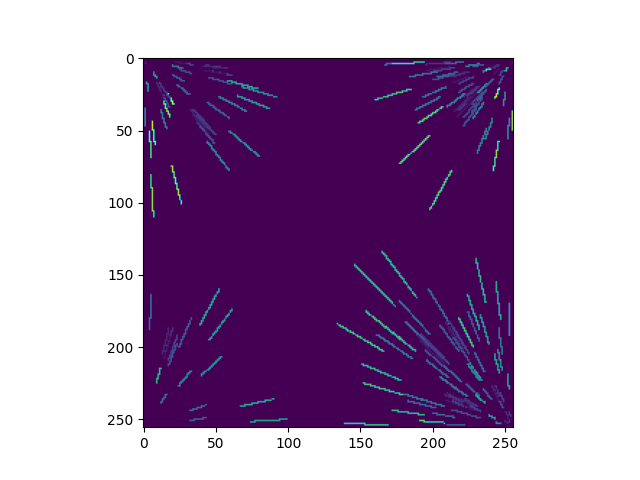

In [15]:
figure()
imshow(blid_grid)

In [16]:
craco_pybind11.ddgrid_reader.krnl_ddgrid_reader_4cu(mainbuf_hw, 
                                     ndm, 
                                     tblk,
                                     nchunk_time, 
                                     nuvrest, 
                                     plan.ddreader_lut, 
                                     do_load_lut, 
                                     outputs[0], 
                                     outputs[1], 
                                     outputs[2], 
                                     outputs[3])

In [17]:
reordered = np.transpose(outputs, [1, 2,0,5, 3,4,6, 7])
#assert reordered.shape == (ndm, nchunk_time, ncu, OUTPUT_NT, nuvrest, NUVWIDE, 2)
reordered = reordered.reshape(ndm, ncu*nchunk_time*OUTPUT_NT, nuvrest*NUVWIDE, 2)

(2, 8, 5136, 2)


<IPython.core.display.Javascript object>


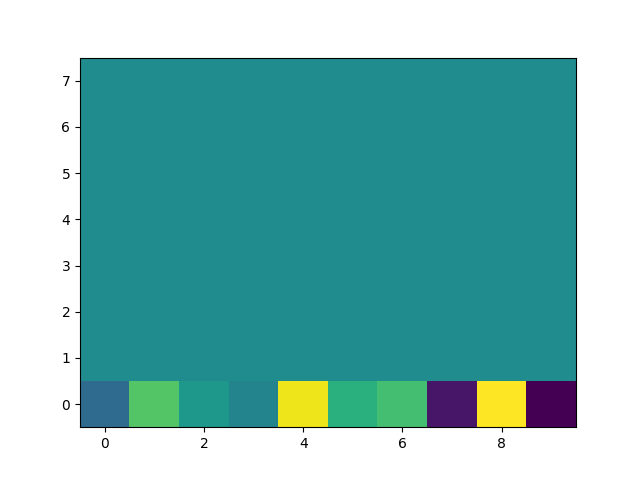

In [18]:
print(reordered.shape)
figure()
imshow(reordered[0,:,:10,0], aspect='auto', origin='lower', interpolation='none')
#print(abs(reordered).sum(), mainbuf.sum())

In [19]:
print(outputs.sum())
print(outputs[1,0,0,:,:,1,0].sum())
for icu in range(outputs.shape[0]):
    print('cu=', icu, outputs[icu, ...].sum())

133642
0
cu= 0 133642
cu= 1 0
cu= 2 0
cu= 3 0


In [20]:
icu=0
load_luts = 1
d_grid = np.zeros((ncu, ndm, nchunk_time, plan.npix, plan.npix, 2), dtype=np.int16)
print(d_grid.sum(), d_grid.shape)
print(nparallel_uvin, ndm, nchunk_time)
print(outputs[icu].shape, outputs[icu].size)
print(outputs[icu].sum())
craco_pybind11.grid.krnl_grid_4cu(ndm,
                     nchunk_time,
                     nparallel_uvin,
                     nparallel_uvout,
                     h_nparallel_uvout,
                     load_luts,
                     lut,
                     outputs[icu],
                     d_grid[icu])
print(d_grid[icu].sum())
print(d_grid.shape)
d = d_grid[0,0,0,:,:,:]


0 (4, 2, 1, 256, 256, 2)
2568 2 1
(2, 1, 642, 4, 2, 2, 2) 41088
133642
111118
(4, 2, 1, 256, 256, 2)


In [21]:
from craft.craco_kernels import FdmtGridder, Imager, Gridder
gridder = FdmtGridder(None, plan, values)
print(mainbuf.shape)
s = mainbuf.shape
expectshape = (plan.nuvrest, plan.ndout,plan.nt,  plan.nuvwide)
din = np.zeros(expectshape, dtype=np.complex64)
print(din.shape)
#mainbuf has extra uvs in them that we wnt to remove
din.real = mainbuf[:plan.nuvrest,:,0,:,:,0]               
din.imag = mainbuf[:plan.nuvrest,:,0,:,:,1]                              
din = din.transpose([0,2,1,3])
print(din.shape)
print(expectshape)
grid = gridder(0, 0, din)
print(grid.shape)

(664, 186, 11, 256, 8, 2)
(642, 186, 256, 8)
(642, 256, 186, 8)
(642, 186, 256, 8)
(256, 256)


In [22]:
def pgrid(ax):
    ax.plot([0,256],[0,256])
    ax.plot([0,256],[128,128])
    ax.plot([128,128],[0,256])

def complex_compare(grid, d, title1='python', title2='HW'):
    fig, ax = subplots(2,3, sharex=True, sharey=True)
    if np.iscomplexobj(d):
        dr = d.real
        di = d.imag
    else:
        dr = d[...,0]
        di = d[...,1]
    diffr = grid.real - dr
    diffi = grid.imag - di
    #diffr[diffr == 0] = np.nan
    #diffi[diffi == 0] = np.nan

    kwargs = {'aspect':'auto'} #, 'origin':'lower'}
    ax[0,0].imshow(grid.real, **kwargs)
    ax[0,1].imshow(dr, **kwargs)
    ax[0,2].imshow(diffr, **kwargs)
    
    pgrid(ax[0,0])
    pgrid(ax[0,1])


    ax[1,0].imshow(grid.imag, **kwargs)
    ax[1,1].imshow(di, **kwargs)
    ax[1,2].imshow(diffi, **kwargs)

    ax[0,0].set_title(f'{title1} max={grid.real.max():0.1e}')
    ax[0,1].set_title(f'{title2} max={dr.max():0.1e}')
    ax[0,2].set_title(f'diff {diffr.std():0.1e} {diffi.std():0.1e}')

    ax[0,0].set_ylabel('real')
    ax[1,0].set_ylabel('imag')

    fig.set_size_inches([10,6])
    print(f'DIfference {diffr.std()} {diffi.std()}')
    


<IPython.core.display.Javascript object>


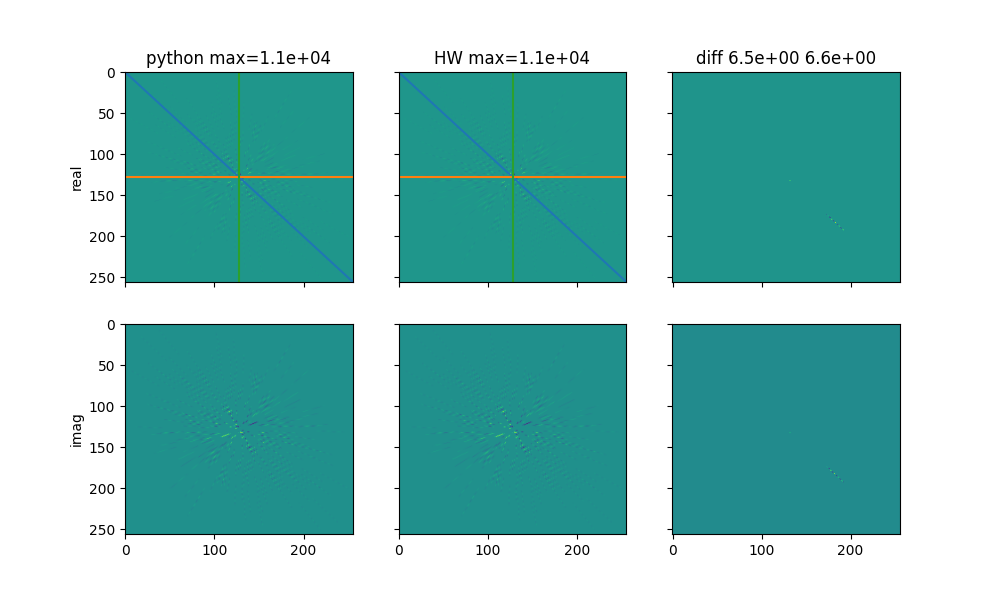

DIfference 6.538243576824521 6.609751619535841


In [23]:
dc = d[:,:,0] + 1j*d[:,:,1]
complex_compare(np.fft.fftshift(grid), np.fft.fftshift(dc))

<IPython.core.display.Javascript object>


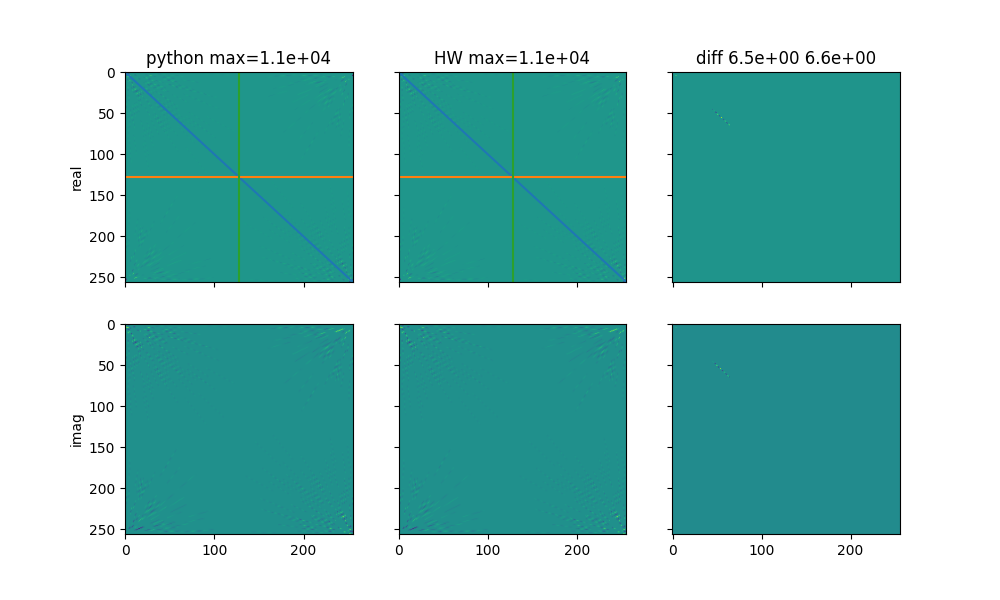

DIfference 6.538243576824521 6.609751619535841


In [24]:
complex_compare(grid, dc)

In [25]:
np.where(grid.real != 0)

(array([  1,   1,   2, ..., 254, 255, 255]),
 array([  3,   4,  34, ..., 222, 252, 253]))

In [26]:
np.where(dc.real != 0)

(array([  1,   1,   2, ..., 254, 255, 255]),
 array([  3,   4,  34, ..., 222, 252, 253]))

In [27]:
c = plan.fdmt_plan.runs[0].cells[0]
print(c.uvpix_upper)
print(c.uvpix_lower)

(252, 7)
(4, 249)


In [28]:
from craft.craco import image_fft

def dofft(grid):
    ndm, nchunk, npix, _, _ = grid.shape
    images = np.zeros((ndm, nchunk, npix, npix, 2), dtype=np.float32)
    for dm in range(ndm):
        for chunk in range(nchunk):
            g = np.zeros((npix, npix), dtype=np.complex64)
            g.real = grid[dm, chunk, :, :, 0]
            g.imag = grid[dm, chunk, :, :, 1]
            #img = image_fft(g, scale='prod')
            img = np.fft.fftshift(np.fft.fft2(g))
            images[dm, chunk, :, :, 0] = img.real
            images[dm, chunk, :, :, 1] = img.imag         
    
    return images

d_grid.shape

(4, 2, 1, 256, 256, 2)

In [29]:
np.all(grid.real - d_grid[0,0,0,:,:,0] == 0)

False

In [30]:
np.all(grid.imag - d_grid[0,0,0,:,:,1] == 0)

False

In [31]:
np.sum(grid != 0)

6704

In [32]:
hwimages = dofft(d_grid[0,...])
imgr = Imager(None, plan, values)
#pyimages = imgr(grid)
pyimages = np.fft.fftshift(np.fft.fft2(grid))

<IPython.core.display.Javascript object>


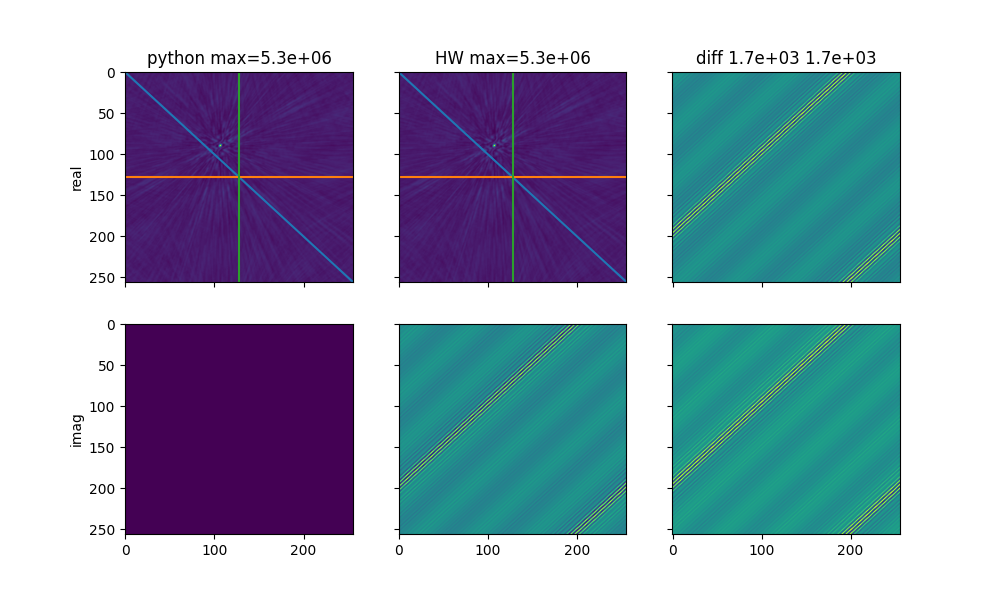

DIfference 1682.969420129119 1682.96940527728


In [33]:
complex_compare(pyimages, hwimages[0,0,...])

<IPython.core.display.Javascript object>


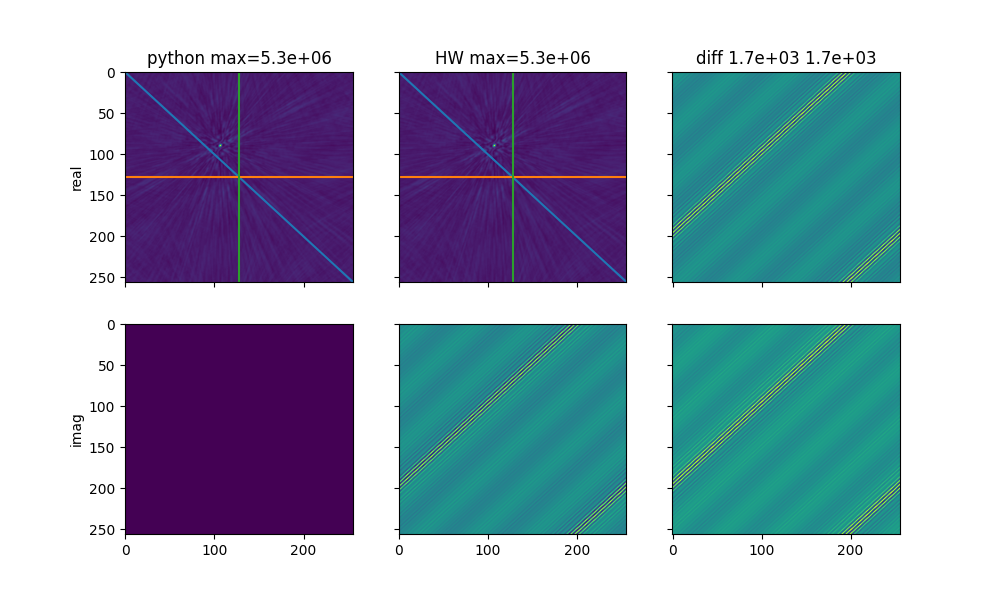

DIfference 1682.969420129119 1682.96940527728


In [34]:
complex_compare(pyimages, hwimages[0,0,...])

In [35]:
grid.sum()

(56154+0j)

In [36]:
pyimages.max()

(5265020.30397349+0j)

In [37]:
grid.sum() == pyimages.max()

False

In [45]:
import pyxrt
device = pyxrt.device(1)
xclbin = '/data/craco/ban115/builds/binary_container_fe3fef0d.xclbin'
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)

In [46]:
alloc_device_only = True
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allo

In [47]:
dpoint.shape

(190, 256)

In [48]:
din = np.zeros((plan.nbl, plan.nf, plan.nt), dtype=np.complex64)
din[:,:,:] = dpoint[:,:,np.newaxis]

In [49]:
p.copy_input(din, values)

In [50]:
values.run_fdmt = True
values.run_image = True
tblk=0
p.run(tblk, values).wait()

In [51]:
duv = p.inbuf.copy_from_device().nparr
duv.shape

(642, 256, 32, 8, 2)

In [52]:
mainbuf2 = p.copy_mainbuf()


In [53]:
mainbuf.shape

(664, 186, 11, 256, 8, 2)

In [54]:
mainbuf2.shape

(648, 186, 11, 256, 8, 2)

In [55]:
mainbuf_hw.shape

(664, 186, 11, 256, 8, 2)

<IPython.core.display.Javascript object>


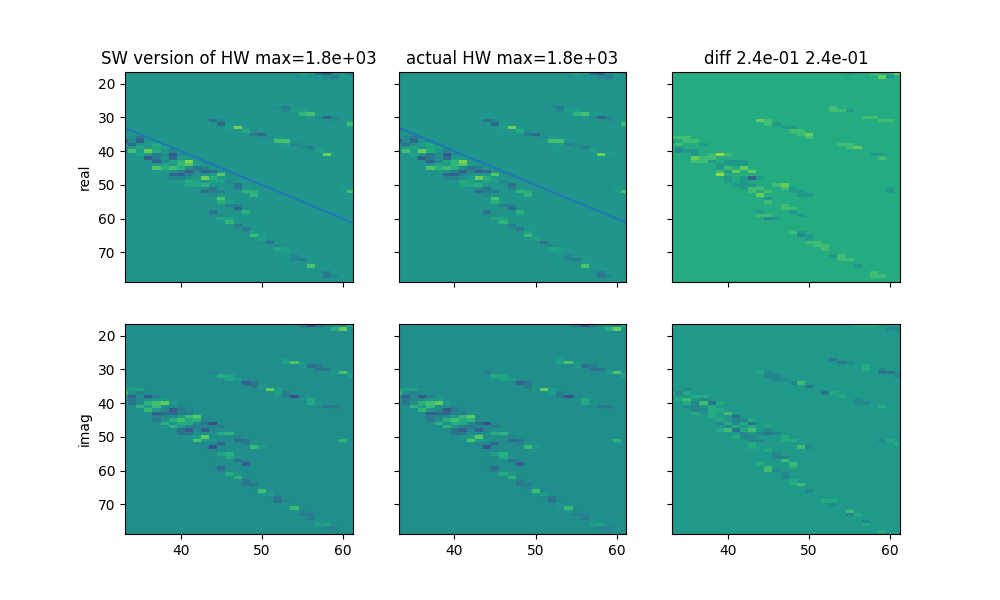

DIfference 0.24347282200468756 0.2393992239663396


In [56]:
def gridmb(mb, tblk=0):
    ''' Careful this only grids half of the data - so ... be careful'''
    g = np.zeros((npix,npix), dtype=np.complex)
    for irun, r in enumerate(plan.fdmt_plan.runs):
        for icell, c in enumerate(r.cells):
            u,v = c.uvpix
            d = mb[irun,0,0,0,icell,:]
            g.real[v,u] = d[0]
            g.imag[v,u] = d[1]
            
    return g

g_py = gridmb(mainbuf)
g_hw = gridmb(mainbuf2)
g_sw = gridmb(mainbuf_hw)

complex_compare(g_sw, g_hw, 'SW version of HW', 'actual HW')
            

In [57]:
list(filter(lambda cell: cell.uvpix_upper == (22,3), plan.uvcells))

[Cell blid=264.0 chan=0-20 freq=734499993.896500-754499994.846500 uvpix=(22, 3) upper_idx=784 uvpix_upper=(22, 3)]

In [58]:
plan.fdmt_plan.find_uv((22,3))

[(6, 0)]

In [59]:
plan.fdmt_plan.runs[6].cells[1]

Cell blid=4884.0 chan=5-24 freq=739499994.134000-758499995.036500 uvpix=(16, 24) upper_idx=32604 uvpix_upper=(240, 232)

In [60]:
plan.baseline_order.index(264.0)

6

In [61]:
dpoint.shape

(190, 256)

In [62]:
dpoint[6, 0:21].sum()

(-629.91614-1176.4838j)

In [63]:
np.round(dpoint[6, 0:21]).sum()

(-632-1176j)

In [64]:
g_sw[3,22]

(-629-1176j)

In [65]:
g_hw[3,22]

(-632-1176j)

In [66]:
bchist = p.boxcar_history.copy_from_device().nparr
bchist.shape

(1024, 7, 256, 256)

<IPython.core.display.Javascript object>


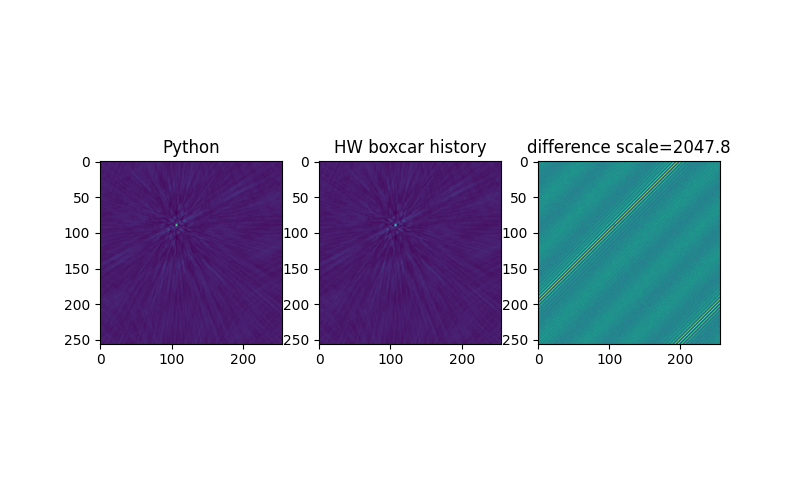

Text(0.5, 1.0, 'difference scale=2047.8')

In [67]:
fig, ax = subplots(1,3)
fig.set_size_inches((8,5))
i1 = pyimages.real
i2 = np.fft.fftshift(bchist[0,0,:,:]).T

scale = i1.max() / i2.max()
d = i1/i1.max() - i2/i2.max()
ax[0].imshow(i1/i1.max())
ax[1].imshow(i2/i2.max())
ax[2].imshow(d)
scale
ax[0].set_title('Python')
ax[1].set_title('HW boxcar history')
ax[2].set_title(f'difference scale={scale:0.1f}')

<IPython.core.display.Javascript object>


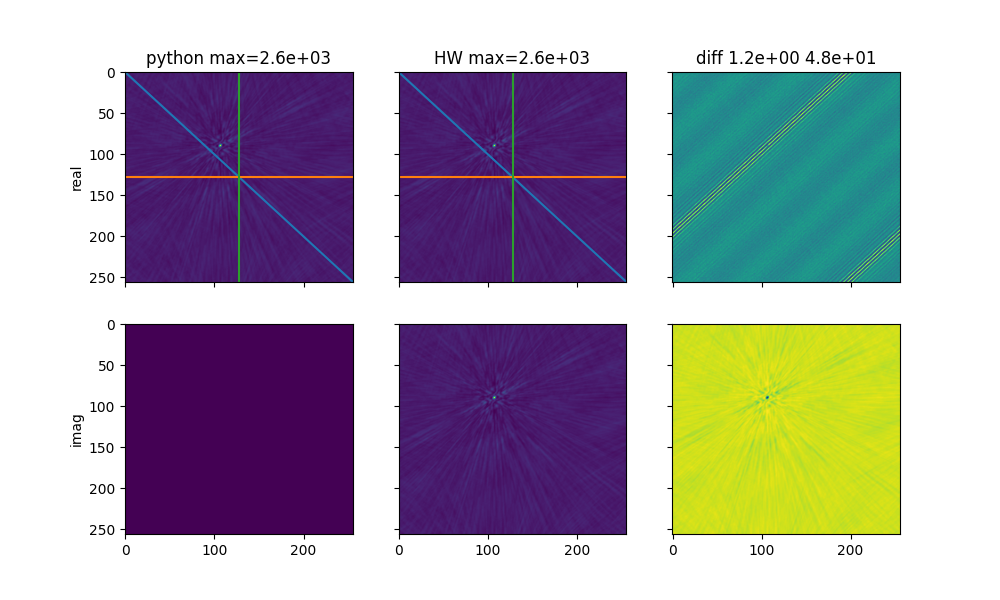

DIfference 1.1970049831724736 48.26676182193035


In [68]:
i1 = pyimages/scale
i2 = np.fft.fftshift(bchist[0,1,:,:]+1j*bchist[0,0,:,:]).T
complex_compare(i1, i2)

<IPython.core.display.Javascript object>


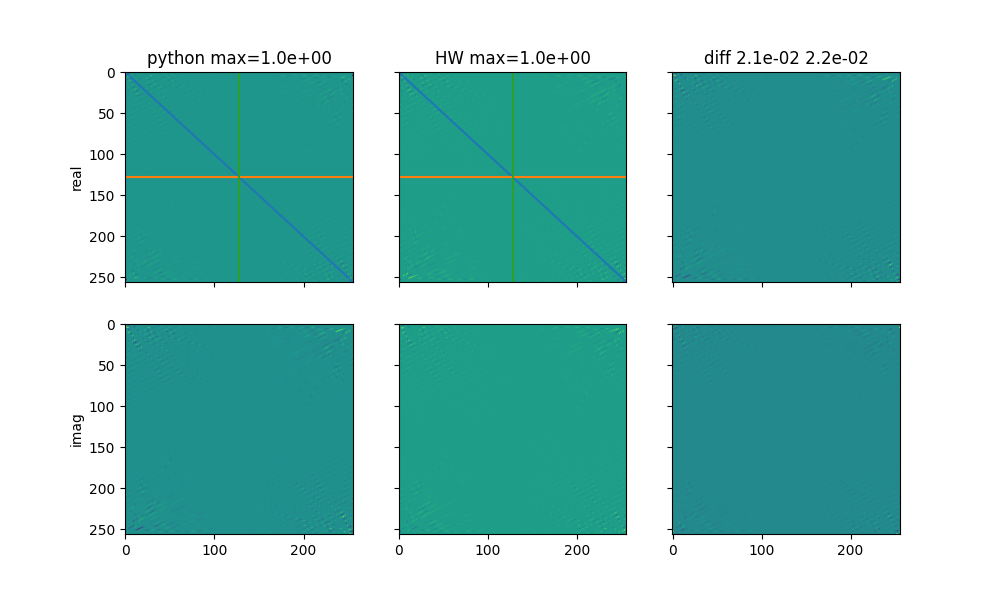

DIfference 0.021141410127325712 0.02152509384127324


In [69]:
g1 = np.fft.ifft2(np.fft.ifftshift(i1))
g2 = np.fft.ifft2(np.fft.ifftshift(i2))
complex_compare(g1/g1.real.max(), g2/g2.real.max())

# Sweep through LM

In [70]:
dpoint.shape

(190, 256)

In [71]:
expectshape = (plan.nuvrest, plan.nt, plan.ndout, plan.nuvwide)
din = np.zeros(expectshape, dtype=np.complex64)
loffs = np.linspace(0, 1, plan.nt)
loffs = np.arange(0,0.1,0.01)*0.18

for iloff, loff in enumerate(loffs):
    dpoint = pointsource(64,(loff, 0), plan)
    print(iloff,loff)
    for irun, r in enumerate(plan.fdmt_plan.runs):
        for icell, c in enumerate(r.cells):
            blid = c.blid
            ibl = np.where(plan.baseline_order == blid)[0][0]
            assert plan.baseline_order[ibl] == blid
            v = dpoint[ibl, c.chan_slice].sum()
            din[irun, iloff, 0, icell] = v


0 0.0
1 0.0018
2 0.0036
3 0.005399999999999999
4 0.0072
5 0.009
6 0.010799999999999999
7 0.0126
8 0.0144
9 0.0162


<IPython.core.display.Javascript object>


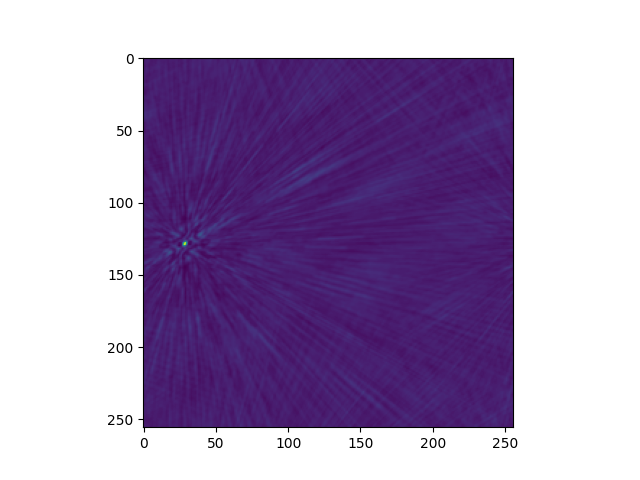

In [72]:

def getpeak(img):
    peakidx = np.argmax(img)
    peakpix = np.unravel_index(peakidx, img.shape)
    peakval = np.max(img)
    y,x = peakpix
    peaksum = img[y-1:y+2,x-1:x+2].mean()
    return peakpix[0], peakpix[1], peakval,peaksum

    
gridder.plan.npix = 256
stats = []
for i in range(len(loffs)//2):
    grid = gridder(0, i, din)
    img = np.fft.fftshift(np.fft.fft2(grid))
    stats.append(getpeak(img.real))
    stats.append(getpeak(img.imag))
    
stats = np.array(stats)
figure()
imshow(img.imag)
    

In [73]:
stats.shape

(10, 4)

<IPython.core.display.Javascript object>


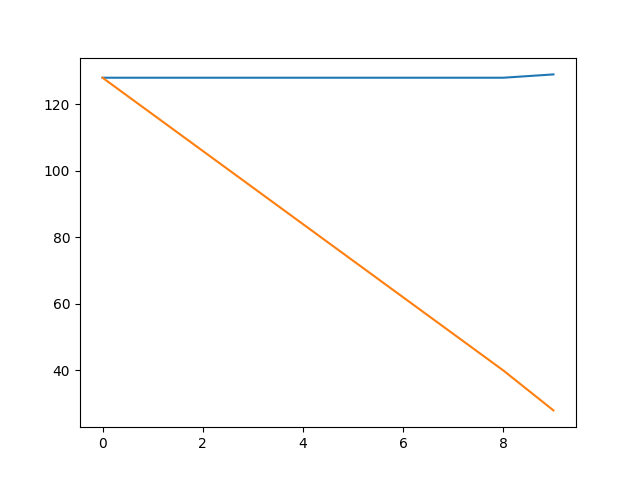

In [74]:
figure()
plot(stats[:,0])
plot(stats[:,1])

<IPython.core.display.Javascript object>


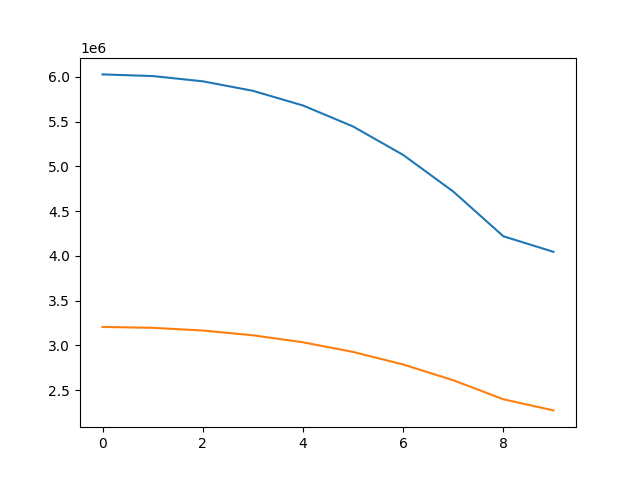

In [75]:
figure()
plot(stats[:,2])
plot(stats[:,3])

In [76]:
din.shape

(642, 256, 186, 8)

In [82]:
noiseamp = 17
N = 1024
d = noiseamp*(np.random.randn(N) + 1j*np.random.randn(N))
qnoise = np.sqrt(d.real.std()**2 + d.imag.std()**2)/np.sqrt(2)
print(f'{d.real.std()} {d.imag.std()} {qnoise}')

17.065763106248543 17.4261846444088 17.246915400436436


In [88]:
d = np.ma.masked_array(np.arange(10), [False]*10)
d

masked_array(data=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999)

In [91]:
d.mask[3] = True
d

masked_array(data=[0, 1, 2, --, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False,  True, False, False, False, False,
                   False, False],
       fill_value=999999)

In [96]:
d.size - sum(d.mask)

9